1. This notebook implements SARSA algorithm.

2. While implementing the sarsa algorithm, Q-function used is a function of state,prev_reward,action.

3. The action select policy is decay epsilon algorithm.

In [2]:
!pip3 install -e gym-env
# !pip3 install pygame

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/kabhay/Documents/courses/RL_project/Foraging_in_replenishing_patches/gym-env
  Attempting uninstall: gym-env
    Found existing installation: gym-env 0.0.1
    Uninstalling gym-env-0.0.1:
      Successfully uninstalled gym-env-0.0.1
  Running setup.py develop for gym-env
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import gym
from gym import error, spaces, utils
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

In [4]:
from blocks import EnvClass

In [5]:
def playEnv(env,policy):
    
    env.reset()
    
    s = env.present_state
    
    done = False

    a = int(policy[s][0])

    cur_reward = 0

    while not done:

        out = env.step(a)

        (s_prime,t),r,done,_ = out
        
        cur_reward += r
        a = int(policy[int(s_prime)][int(r)])
        
    return cur_reward

In [6]:
def decayEpsilon(eps,noEpisodes,decayUntil,min_eps=0.01,decayType='linear'):
    
    epsilons = np.empty(noEpisodes)
    
    epsilons.fill(min_eps)
    
    if decayType == 'linear':
        
        rate = (eps - min_eps) / decayUntil
        
        for i in range(decayUntil+1):
            epsilons[i] = eps - i*rate
    
    else :
        
        rate = (eps/min_eps)** (1/decayUntil)
        
        for i in range(decayUntil+1):
            epsilons[i] = eps * (rate**i)

    
    return epsilons

In [7]:
def decayAlpha(alpha, noEpisodes,maxSteps,final_alpha = 0.01,decayType='linear'):
    
    alphas = [float(final_alpha)] * noEpisodes
    
    if decayType == 'linear':
        
        rate = (alpha - final_alpha) / maxSteps
        
        for i in range(maxSteps+1):
            alphas[i] = alpha - i*rate
    
    else :
        
        rate = (final_alpha/alpha)** (1/maxSteps)
        
        for i in range(maxSteps+1):
            alphas[i] = alpha * (rate**i)
    
    return alphas

In [8]:
def actionSelect(s,r,Q,eps):
    
    q = Q[s][r]
    
    if np.random.rand() > eps:
        a = np.random.choice(np.where(q == q.max())[0])
    else :
        a = np.random.randint(0,len(q))
    
    return a

In [9]:
def GreedyPolicy(Q):
    
    pi = np.zeros((Q.shape[0],Q.shape[1]))
    
    for s in range(Q.shape[0]):
        
        for r in range(Q.shape[1]):
            
            q = Q[s][r]

            #simple_argmax

            a = np.argmax(q)

            #a = np.random.choice(np.where(q == q.max())[0])

            pi[s][r] = int(a)
        
    return pi

In [10]:
from tqdm import tqdm

In [17]:
#reference : lecture slides

def SARSA(env,gamma,alpha,eps,noEpisodes,epsilons = [0]) :
    
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    Q = np.zeros((n_states,201,n_actions))
    
#     Q_s = np.zeros((noEpisodes,n_states,20,n_actions))
    if epsilons[0] == 0:
        epsilons = decayEpsilon(eps,noEpisodes,noEpisodes,min_eps = 0.1, decayType = 'linear')
        
    alphas = decayAlpha(alpha,noEpisodes,int(3*noEpisodes/4) ,final_alpha = 0.02 ,decayType = 'linear')
    
    rewards = np.zeros((noEpisodes)) 
    greedy_rewards = np.zeros((noEpisodes)) 
    
    for e in tqdm(range(noEpisodes)):
        
        cur_alpha = alphas[e]
        cur_eps = epsilons[e]
        env.reset()
        s = env.present_state
        done = False
        
        a = actionSelect(s,0,Q,cur_eps)
        
        cur_reward = 0

        r = 0
        
        
        while not done:

            out = env.step(a)
            
            (s_prime,t),r_new,done,_ = out
            
#             s_prime,t = f
                
            cur_reward += r_new
            
            
            a_prime = actionSelect(s_prime,int(r_new),Q,cur_eps)
            
            td_target = r_new
            
            if not done :
                td_target += gamma * Q[s_prime][int(r_new)][a_prime]
                
            td_error = td_target - Q[s][int(r)][a]
                
            Q[s][int(r)][a] = Q[s][int(r)][a] + cur_alpha * td_error
            
            s = s_prime
            
            a = a_prime
            
            r = r_new
            
        rewards[e] = cur_reward
        greedy_rewards[e]=playEnv(env,GreedyPolicy(Q))
        
    pi = GreedyPolicy(Q)
#     V = np.max(Q,axis=2)
    
    return Q,pi,rewards,greedy_rewards
    

In [18]:
envs = EnvClass()

## EXPERIMENTATION

### Block1

In [19]:
env_b1 = envs.getBlock(1)
num_seeds = 5

n_states = 9
n_actions = 8

alpha = 0.5
gamma = 0.4
eps = 1
noEpisodes = 10000

Q_ = np.zeros((num_seeds, n_states,201,n_actions)) 
rewards_ = np.zeros((num_seeds,noEpisodes))
greedy_rewards_ = np.zeros((num_seeds,noEpisodes))

In [20]:
for i in range(1,num_seeds):    
    np.random.seed(4*i)
    epsilons = np.ones((noEpisodes))
    epsilons = decayEpsilon(eps,noEpisodes,19*noEpisodes//20, min_eps = 0.01, decayType = 'linear')
    Q_[i],pi1,rewards_[i],greedy_rewards_[i] = SARSA(env_b1,gamma,alpha,eps,noEpisodes,epsilons)

100%|██████████| 10000/10000 [02:30<00:00, 66.30it/s]


In [21]:
avg_rewards = np.mean(rewards_[1:],axis = 0)

In [22]:
Q_avg = np.mean(Q_[1:4],axis = 0)

In [23]:
def GreedyPolicy(Q):
    
    pi = np.zeros((Q.shape[0],Q.shape[1]))
    
    for s in range(Q.shape[0]):
        
        for r in range(Q.shape[1]):
            
            q = Q[s][r]

            #simple_argmax

            a = np.argmax(q)

            #a = np.random.choice(np.where(q == q.max())[0])

            pi[s][r] = int(a)
        
    return pi

In [24]:
pi_ = GreedyPolicy(Q_avg)

In [25]:
playEnv(env_b1,pi_)

19085

In [26]:
pi_

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [6., 0., 0., ..., 0., 0., 0.],
       [6., 0., 0., ..., 0., 0., 0.],
       [6., 0., 0., ..., 0., 0., 0.]])

In [27]:
for i in range(num_seeds):
    pi = GreedyPolicy(Q_[i])
    print(playEnv(env_b1,pi))

0
18951
17935
20126
16882


In [28]:
np.savez('./policies/sarsa/sarsa_learning_gamma_04_B1_reward.npz', rewards_)
np.savez('./policies/sarsa/sarsa_learning_gamma_04_B1_policy.npz', pi_)
np.savez('./policies/sarsa/sarsa_learning_gamma_04_B1_greedy.npz', greedy_rewards_)

In [56]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

In [37]:
new_rewards = [rewards_[1]]
for i in range(2,len(rewards_)):
    cur_avg = (i * new_rewards[-1] + rewards_[i])/(i+1)
    new_rewards.append(cur_avg)

### Block2

In [30]:
env_b2 = envs.getBlock(2)
num_seeds = 5

n_states = 9
n_actions = 8

alpha = 0.5
gamma = 0.4
eps = 1
noEpisodes = 10000

Q_ = np.zeros((num_seeds, n_states,201,n_actions)) 
rewards_ = np.zeros((num_seeds,noEpisodes))
greedy_rewards_ = np.zeros((num_seeds,noEpisodes))

In [31]:
for i in range(1,num_seeds):    
    np.random.seed(5+i)
    epsilons = np.ones((noEpisodes))
    epsilons = decayEpsilon(eps,noEpisodes,19*noEpisodes//20, min_eps = 0.01, decayType = 'linear')
    Q_[i],pi2,rewards_[i],greedy_rewards_[i] = SARSA(env_b2,gamma,alpha,eps,noEpisodes,epsilons)

100%|██████████| 10000/10000 [02:42<00:00, 61.64it/s]


In [32]:
avg_rewards = np.mean(rewards_,axis = 0)
print(avg_rewards.shape)

(10000,)


In [33]:
for i in range(num_seeds):
    pi = GreedyPolicy(Q_[i])
    print(playEnv(env_b2,pi))

0
20242
19350
18857
20989


In [34]:
Q_avg = np.mean(Q_[1:],axis = 0)

In [35]:
def GreedyPolicy(Q):
    
    pi = np.zeros((Q.shape[0],Q.shape[1]))
    
    for s in range(Q.shape[0]):
        
        for r in range(Q.shape[1]):
            
            q = Q[s][r]

            #simple_argmax

            a = np.argmax(q)

            #a = np.random.choice(np.where(q == q.max())[0])

            pi[s][r] = int(a)
        
    return pi

In [36]:
pi_ = GreedyPolicy(Q_avg)

In [37]:
playEnv(env_b2,pi_)

20446

In [38]:
np.savez('./policies/sarsa/sarsa_learning_gamma_04_B2_reward.npz', rewards_)
np.savez('./policies/sarsa/sarsa_learning_gamma_04_B2_policy.npz', pi_)
np.savez('./policies/sarsa/sarsa_learning_gamma_04_B2_.greedynpz', greedy_rewards_)

Text(0.5, 1.0, 'SARSA reward for block 2')

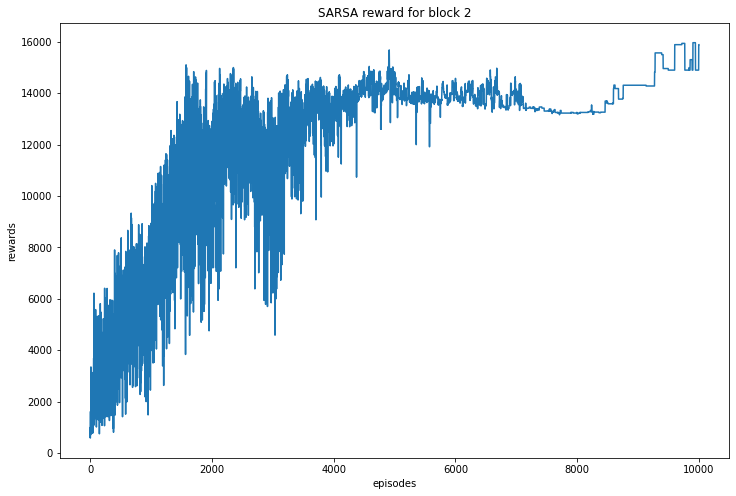

In [41]:
plt.figure(figsize=(12,8))
plt.plot(np.mean(greedy_rewards_,axis=0))
# plt.legend(['v('+ str(i)+')' for i in range(9)],loc='lower right')
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("SARSA reward for block 2")
# plt.savefig('images/sarsa_updated/b2_SARSA_rewards_last.pdf', transparent=True)
# plt.savefig('SARSAb2Reward.jpg', transparent=True)

In [43]:
rewards_[-1,-1]

20989.0

In [44]:
reward = playEnv(env_b2,pi2)

In [45]:
reward

20989

### Block3

In [46]:
env_b3 = envs.getBlock(3)
num_seeds = 5

n_states = 9
n_actions = 8

alpha = 0.5
gamma = 0.4
eps = 1
noEpisodes = 10000

Q_ = np.zeros((num_seeds, n_states,201,n_actions)) 
rewards_ = np.zeros((num_seeds,noEpisodes))
greedy_rewards_ = np.zeros((num_seeds,noEpisodes))

In [47]:
for i in range(1,num_seeds):    
    np.random.seed(4*i)
    epsilons = np.ones((noEpisodes))
    epsilons = decayEpsilon(eps,noEpisodes,19*noEpisodes//20, min_eps = 0.01, decayType = 'linear')
    Q_[i],pi3,rewards_[i],greedy_rewards_[i] = SARSA(env_b3,gamma,alpha,eps,noEpisodes,epsilons)

100%|██████████| 10000/10000 [09:17<00:00, 17.95it/s]  


In [48]:
avg_rewards = np.mean(rewards_,axis = 0)
print(avg_rewards.shape)

(10000,)


In [49]:
for i in range(num_seeds):
    pi = GreedyPolicy(Q_[i])
    print(playEnv(env_b3,pi))

517
23484
23618
23615
23219


In [50]:
Q_avg = np.mean(Q_[1:],axis = 0)

In [51]:
def GreedyPolicy(Q):
    
    pi = np.zeros((Q.shape[0],Q.shape[1]))
    
    for s in range(Q.shape[0]):
        
        for r in range(Q.shape[1]):
            
            q = Q[s][r]

            #simple_argmax

            a = np.argmax(q)

            #a = np.random.choice(np.where(q == q.max())[0])

            pi[s][r] = int(a)
        
    return pi

In [52]:
pi_ = GreedyPolicy(Q_avg)

In [53]:
playEnv(env_b3,pi_)

23192

In [54]:
np.savez('./policies/sarsa/sarsa_learning_gamma_04_B3_reward.npz', rewards_)
np.savez('./policies/sarsa/sarsa_learning_gamma_04_B3_policy.npz', pi_)
np.savez('./policies/sarsa/sarsa_learning_gamma_04_B3_greedy.npz', greedy_rewards_)

In [174]:
env_b3 = envs.getBlock(3)
np.random.seed(10)

In [175]:
noEpisodes = 10000
epsilons = np.ones((noEpisodes))
learn = 500
epsilons[learn:] = decayEpsilon(1,noEpisodes-learn,min_eps = 0.1, rate = 1/(noEpisodes-learn), decayType = 'linear')


In [177]:
Q,pi3,rewards = SARSA(env_b3,0.95,0.5,1,noEpisodes,epsilons)

100%|██████████| 10000/10000 [01:09<00:00, 143.79it/s]


In [178]:
print(pi3)

[[3. 0. 0. ... 0. 0. 0.]
 [6. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [6. 0. 6. ... 0. 0. 0.]
 [6. 0. 0. ... 0. 0. 0.]
 [6. 0. 0. ... 0. 0. 0.]]


In [41]:
v_r = np.max(Q_s,axis=2)

Text(0.5, 1.0, 'SARSA estimates for block 2')

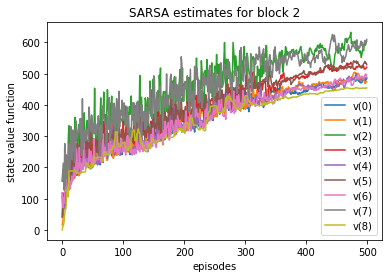

In [42]:
plt.plot(v_r)
plt.legend(['v('+ str(i)+')' for i in range(9)],loc='lower right')
plt.xlabel("episodes")
plt.ylabel("state value function")
plt.title("SARSA estimates for block 2")

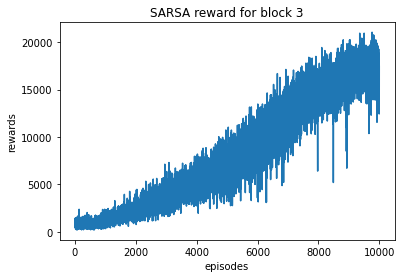

In [182]:
plt.plot(rewards)
# plt.legend(['v('+ str(i)+')' for i in range(9)],loc='lower right')
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("SARSA reward for block 3")
plt.savefig('images/sarsa_updated/b3_SARSA_rewards.pdf', transparent=True)

In [179]:
reward = playEnv(env_b3,pi3)

In [185]:
rewards[-1]

17429.0

In [183]:
new_rewards = [rewards[0]]
for i in range(1,len(rewards)):
    cur_avg = (i * new_rewards[-1] + rewards[i])/(i+1)
    new_rewards.append(cur_avg)

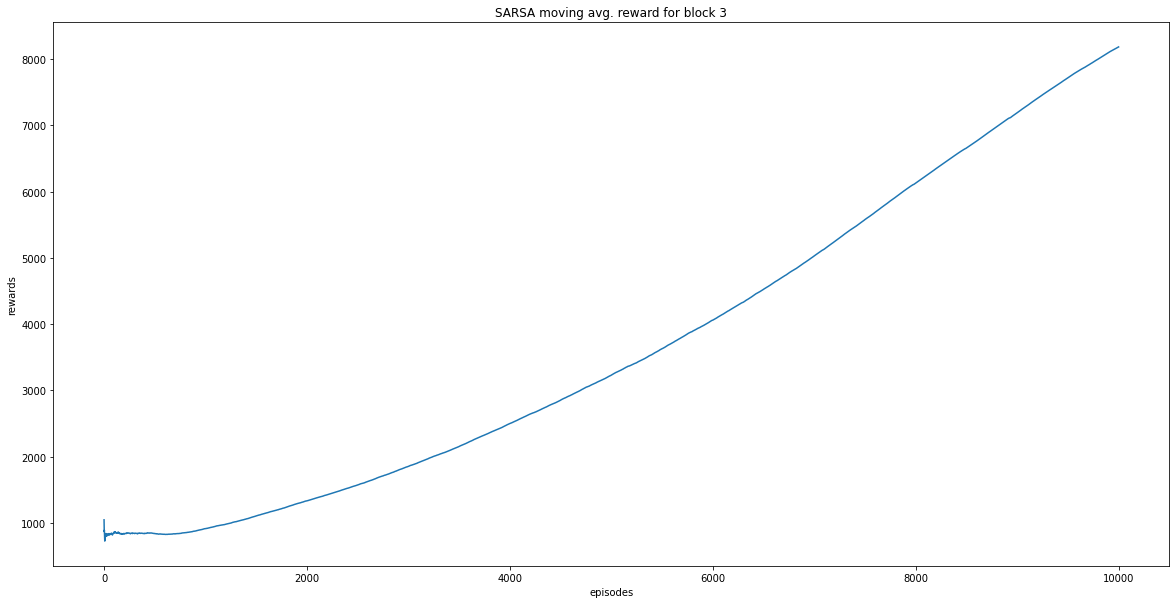

In [184]:
plt.figure(figsize=(20,10))
plt.plot(new_rewards)
# plt.legend(['v('+ str(i)+')' for i in range(9)],loc='lower right')
plt.xlabel("episodes")
plt.ylabel("rewards")
plt.title("SARSA moving avg. reward for block 3")
plt.savefig('images/sarsa_updated/b3_SARSA_cum_rewards.pdf', transparent=True)